In [ ]:
import jax
from jax.config import config   
config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import lax
from jax.experimental import ode 
from jax.experimental import stax
from jax.experimental import optimizers
from jax.experimental.stax import Dense, Flatten, Softplus
from jax.nn.initializers import normal
import math 
import numpy as np
import matplotlib.pyplot as plt 
from IPython import display

In [ ]:
!nvidia-smi
jax.devices()

Thu Jul  1 14:17:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

[GpuDevice(id=0, process_index=0)]

We'd like to study thermodynamic property of the classcial Coulomb gas, whose Hamiltonian reads

$$H= \sum_{i<j} \frac{1}{|\boldsymbol{x}_i - \boldsymbol{x}_j|} + \sum_i  \frac{\boldsymbol{x}_i^2 }{2}. $$
The second term is a harmonic trapping potential. It makes our story easier (no need to consider periodic bondary condition or Ewald sum for long range interaction.)

The way to go is to minimize the variationial free energy with respect to a variational probability density $p(\boldsymbol{x})$

$$\mathcal{L} = \mathbb{E}_{\boldsymbol{x} \sim p(\boldsymbol{x})} \left [ \ln p(\boldsymbol{x}) + \beta H(\boldsymbol{x}) \right] \ge -\ln Z, $$ 
where $Z = \int d \boldsymbol{x} e^{-\beta H}$ and $\beta$ is the inverse temperature. The equality holds when $p(\boldsymbol{x}) = e^{-\beta H}/Z$, i.e., we achieve the exact solution. 



First thing first, here is the energy function

In [ ]:
def energy(x, n, dim):
    i, j = np.triu_indices(n, k=1)
    r_ee = jnp.linalg.norm((jnp.reshape(x, (n, 1, dim)) - jnp.reshape(x, (1, n, dim)))[i,j], axis=-1) 
    v_ee = jnp.sum(1/r_ee)
    return jnp.sum(x**2/2) + v_ee 

The probablistic model we are going to use is the continuous normaliznig flow https://arxiv.org/abs/1806.07366. This is not going to be the most effecient approach. But it is certainly fun! 

In a nutshell, we integrate these two equations to transform samples and their log-likelihoods:

\begin{eqnarray}
\frac{d \boldsymbol{x} }{d t } & =   \boldsymbol{v}, \tag{1}  \\
\frac{d \ln p (\boldsymbol{x}) }{d t} &  = -\nabla \cdot \boldsymbol{v} \tag{2}. 
\end{eqnarray}

Here $\boldsymbol{v}$ is a velocity field we parametrize using a neural network.


In [ ]:
def flow(params, network, x):
    '''
    flow from z to x
    '''
    def _ode(x, t):
        return network(params, x)

    xt = ode.odeint(_ode, 
                    x, 
                    jnp.array([0.0, 1.0]),
                    rtol=1e-10, atol=1e-10
                    )
    return xt[-1]

def logp(params, network, x):
    '''
    likelihood of given samples
    '''
    
    def base_logp(x):
        return -0.5 * jnp.sum( x**2 + jnp.log(2 * math.pi), axis=-1)

    def _ode(state, t):
        x = state[0]
        return -network(params, x), divergence_fwd(network)(params, x)

    logp = 0.0
    xt, logpt = ode.odeint(_ode, 
                           [x, logp], 
                           jnp.array([0.0, 1.0]),
                           rtol=1e-10, atol=1e-10
                           )
    return -logpt[-1] + base_logp(xt[-1])

def divergence_fwd(f):
    def _div_f(params, x):
        jac = jax.jacfwd(lambda x: f(params, x))
        return jnp.trace(jac(x))
    return _div_f

Gradient of the objective function is

$$\nabla \mathcal{L} = \mathbb{E}_{\boldsymbol{x} \sim p(\boldsymbol{x})} \left[ f (\boldsymbol{x})  \nabla \ln p(\boldsymbol{x}) \right],$$ 
where $f (\boldsymbol{x}) = \ln p(\boldsymbol{x}) + \beta H(\boldsymbol{x})$. This is known as the REINFORCE algorithm, or score function gradient estimator. See https://arxiv.org/abs/1906.10652 for more details. 


In [ ]:
def make_reinforce_loss(network, n, dim, beta):

    batch_energy = jax.vmap(energy, (0, None, None), 0) 
    batch_logp = jax.vmap(logp, (None, None, 0), 0) 

    def loss(params, x):
    
        entropy = batch_logp(params, network, x)

        f = entropy + beta*batch_energy(x, n, dim) 
        f = jax.lax.stop_gradient(f)

        f_mean = jnp.mean(f)

        f_std = jnp.std(f)/jnp.sqrt(f.shape[0])

        return jnp.mean((f - f_mean) * entropy), (f_mean, f_std)

    return loss


Now we are ready to initialize a network for the velocity field $\boldsymbol{v}$

In [ ]:
batchsize = 8192
n = 6
dim = 2 
beta = 5.0
key = jax.random.PRNGKey(42)

net_init, network = stax.serial(
    Dense(64), 
    Softplus,
    Dense(n*dim)
)

in_shape = (-1, n*dim)
key, subkey = jax.random.split(key, 2)
out_shape, params = net_init(subkey, in_shape)

In [ ]:
loss = make_reinforce_loss(network, n, dim, beta)
value_and_grad = jax.value_and_grad(loss, argnums=0, has_aux=True)

In [ ]:
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-2)
opt_state = opt_init(params)

Here is the training loop. During training we monitor the density and loss histroy. 

<Figure size 864x432 with 0 Axes>

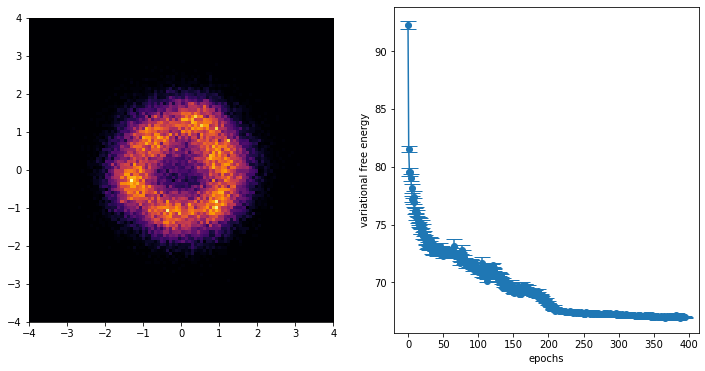

In [ ]:
def step(i, subkey, opt_state):
    params = get_params(opt_state)
    
    x = jax.random.normal(subkey, (batchsize, n*dim)) 
    x = jax.vmap(flow, (None, None, 0), 0)(params, network, x)

    x = jax.lax.stop_gradient(x)

    value, grad = value_and_grad(params, x)

    opt_state = opt_update(i, grad, opt_state)
    return value, opt_state, x

loss_histroy = []
for i in range(500):
    key, subkey = jax.random.split(key)
    value, opt_state, x = step(i, subkey, opt_state)
    _, (f_mean, f_err) = value

    loss_histroy.append([f_mean, f_err])
   
    display.clear_output(wait=True)

    fig = plt.figure(figsize=(12, 6))

    #v = network(get_params(opt_state), x[0]) # velocity on the first sample
    #v = jnp.reshape(v, (n, dim))
    x = jnp.reshape(x, (batchsize*n, dim)) 

    display.clear_output(wait=True)

    fig = plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    #plt.plot(x[:, 0], x[:, 1],'o', alpha=0.5)
    #plt.quiver(x[:, 0], x[:, 1], v[:, 0], v[:, 1])

    #density plot
    H, xedges, yedges = np.histogram2d(x[:, 0], x[:, 1], 
                                       bins=100, 
                                       range=((-4, 4), (-4, 4)),
                        density=True)
    plt.imshow(H, interpolation="nearest", 
               extent=(xedges[0], xedges[-1], yedges[0], yedges[-1]),
               cmap="inferno")

    plt.xlim([-4, 4])
    plt.ylim([-4, 4])

    plt.subplot(1,2,2)
    y = np.reshape(np.array(loss_histroy), (-1, 2))
    plt.errorbar(np.arange(i+1), y[:, 0], yerr=y[:, 1], marker='o', capsize=8)
    plt.xlabel('epochs')
    plt.ylabel('variational free energy')
    plt.pause(0.01)


Do you see structure emerges from training? 
Yes! It is called [Wigner molecule](https://en.wikipedia.org/wiki/Wigner_crystal). Just think about a few marbles in a bow. You got it. 

A few things to improve from this mininist implementation: 
* It seems the training breaks rotational invariance. But it shouldn't. How to incorporate that into the model design ? 

* How about permutation equivariance $\mathcal{P} \boldsymbol{v}(\boldsymbol{x}) = v(\mathcal{P} \boldsymbol{x})$ ?

* Do you feel it is a bit ackward to integrate the equation twice (one for sampling, one for the likelihood). It is actually easier to implement "reparametrization" gradient estimator. Code it and see why we were not using it here. 

* This code is painfully slow for such a tiny problem. This is mainly because we have repeatedly computed divergence $\nabla \cdot \boldsymbol{v}$ of the neural network. See https://arxiv.org/abs/1810.01367 and https://arxiv.org/abs/1912.03579 for ideas of speeding up.






# sandbox

In [ ]:
def divergence_scan_jvp(f):
    def _div_f(params, x):
        n = x.shape[0]
        eye = jnp.eye(n)

        def _body_fun(val, i):
            primal, tangent = jax.jvp(lambda x: f(params, x), (x,), (eye[i],))
            return val + tangent[i], None
                                             
        return lax.scan(_body_fun, 0.0, jnp.arange(0, n))[0]
    return _div_f

def divergence_scan_vjp(f):
    def _div_f(params, x):
        n = x.shape[0]
        eye = jnp.eye(n)

        def _body_fun(val, i):
            primal, vjp = jax.vjp(lambda x: f(params, x), x)
            return val + vjp(eye[i])[0][i], None
                                             
        return lax.scan(_body_fun, 0.0, jnp.arange(0, n))[0]
    return _div_f

def divergence_rev(f):
    def _div_f(params, x):
        jac = jax.jacrev(lambda x: f(params, x))
        return jnp.trace(jac(x))

    return _div_f

In [ ]:
def f(_, x):
    return x**2+x

x = jnp.ones(100)
%timeit divergence_scan_jvp(f)(None, x).block_until_ready() 
%timeit divergence_scan_vjp(f)(None, x).block_until_ready() 
%timeit divergence_fwd(f)(None, x).block_until_ready()  
%timeit divergence_rev(f)(None, x).block_until_ready()  

In [ ]:
%timeit jax.vmap(divergence_scan(network), (None, 0), 0)(params, x).block_until_ready() 
%timeit jax.vmap(divergence_fwd(network), (None, 0), 0)(params, x).block_until_ready() 
%timeit jax.vmap(divergence_rev(network), (None, 0), 0)(params, x).block_until_ready() 

In [ ]:
from jax.scipy.stats import norm
def logp1(x):
    return -0.5 * jnp.sum( x**2 + jnp.log(2 * math.pi), axis=-1)
def logp2(x):
    return jnp.sum(norm.logpdf(x), axis=-1)
key = jax.random.PRNGKey(42)
x = jax.random.normal(key, (4, 2))
jnp.allclose(logp1(x), logp2(x))

DeviceArray(True, dtype=bool)

In [ ]:
%timeit jax.scipy.linalg.solve(A, b).block_until_ready()  

1 loop, best of 5: 1.42 s per loop


In [ ]:
%timeit jax.scipy.sparse.linalg.gmres(Ax, b, tol=1e-6)[0].block_until_ready()  